In [33]:
import pandas as pd
import numpy as np
from gower import gower_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


# Synthetic Data

In [34]:
# Set random seed for reproducibility
np.random.seed(42)
random_seed = 42

# Generate synthetic data for demo
n_samples = 100
# Create age groups with some patterns
age = np.concatenate([
    np.random.normal(25, 3, 30),  # Young group
    np.random.normal(40, 5, 40),  # Middle age group
    np.random.normal(60, 4, 30)   # Senior group
]).round()

# Create education levels with patterns
education_probs = {
    'HS': 0.3,
    'BS': 0.4,
    'MS': 0.2,
    'PhD': 0.1
}
education = np.random.choice(
    list(education_probs.keys()),
    size=n_samples,
    p=list(education_probs.values())
)

# Create income patterns based on age & education
education_multiplier = {
    'HS': 1.0,
    'BS': 1.5,
    'MS': 2.0,
    'PhD': 2.5
}
# Base income increases with age but plateaus
base_income = 30000 + (age - 22) * 1000  # Starting salary ~30k, 1k increase per year of age
base_income = np.minimum(base_income, 80000)  # Plateau at 80k
education_factors = np.array([education_multiplier[edu] for edu in education])
income = base_income * education_factors
# Add some random noise (higher variance for higher base income)
noise_scale = income * 0.1  # 10% noise
noise = np.random.normal(0, noise_scale)
income = income + noise
# Ensure no negative incomes
income = np.maximum(income, 0)  

# Create job sectors with some correlation to education
job_sectors = []
for edu in education:
    if edu == 'PhD':
        sector = np.random.choice(['Research', 'Academia'], p=[0.6, 0.4])
    elif edu in ['MS', 'BS']:
        sector = np.random.choice(['Tech', 'Finance', 'Healthcare'], p=[0.4, 0.3, 0.3])
    else:
        sector = np.random.choice(['Service', 'Sales', 'Admin'], p=[0.4, 0.3, 0.3])
    job_sectors.append(sector)

# Create experience years correlated with age
experience = (age - 22 + np.random.normal(0, 2, n_samples)).round()
experience = np.maximum(experience, 0)  # No negative experience

# Create satisfaction scores
satisfaction = np.random.randint(1, 6, n_samples)  

# Combine into DataFrame
df = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Education': education,
    'Job_Sector': job_sectors,
    'Experience': experience,
    'Satisfaction': satisfaction
})

# Gower Distance with Weighted Columns

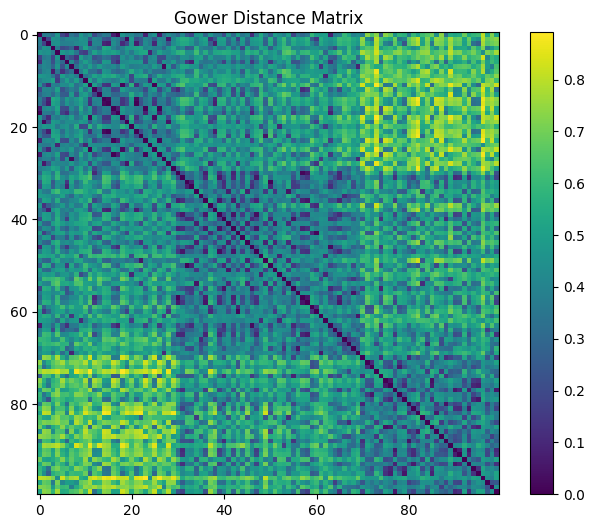

In [35]:
categorical_features = np.array([
    col in df.select_dtypes(include=['object', 'category']).columns 
    for col in df.columns
])

# Assian equal weights for each column, except for `Satisfaction` which gets a higher weight
weight = np.array([1.0] * len(df.columns))  
satisfaction_idx = df.columns.get_loc('Age')
weight[satisfaction_idx] = 1.5

# Calculate Gower distance
gower_dist = gower_matrix(df, cat_features=categorical_features, weight=weight)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(gower_dist)
plt.colorbar()
plt.title('Gower Distance Matrix')
plt.show()

# Perform clustering with a selected algorithm

Feeding the gower distance matrix to a clustering algorithm is very simple, similar to feeding the original data to a clustering algorithm, pls see a quick demo below.

In [36]:
# Perform clustering with a selected algorit
n_clusters = 4  

clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='complete'
)
clusters = clustering.fit_predict(gower_dist)

# Add clusters to dataframe
df['Cluster'] = clusters


# Visualization of Clusters

## Rador Plot

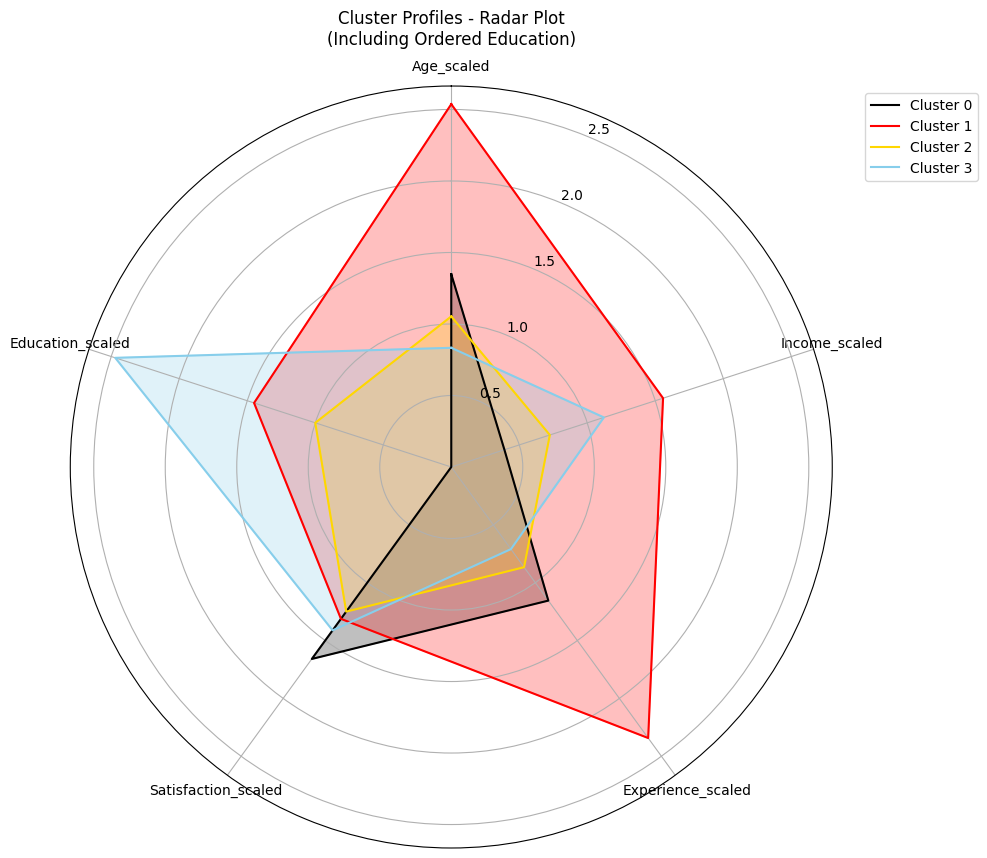

In [37]:
df_plot = df.copy()
colors = {
    0: '#000000',    # black
    1: '#FF0000',    # red
    2: '#FFD700',    # yellow (gold)
    3: '#87CEEB'     # light blue (sky blue)
}

education_order = ['HS', 'BS', 'MS', 'PhD']
edu_encoder = OrdinalEncoder(categories=[education_order])
df_plot['Education_encoded'] = edu_encoder.fit_transform(df_plot[['Education']])
le_job = LabelEncoder()
df_plot['Job_Sector_encoded'] = le_job.fit_transform(df_plot['Job_Sector'])

# Include Education_encoded in the features to be scaled
feature_cols = ['Age', 'Income', 'Experience', 'Satisfaction', 'Education_encoded']
scaled_cols = ['Age_scaled', 'Income_scaled', 'Experience_scaled', 
               'Satisfaction_scaled', 'Education_scaled']

# Scale all features to [0,3]
scaler = MinMaxScaler(feature_range=(0, 3))
scaled_features = scaler.fit_transform(df_plot[feature_cols])

# Create scaled DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=scaled_cols)
df_scaled['Cluster'] = df_plot['Cluster']

# Calculate cluster means for numeric and ordinal features
categories = scaled_cols
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # complete the circle

# Create the figure
fig = plt.figure(figsize=(10, 12))  
ax = fig.add_subplot(111, projection='polar')

# Plot data
for cluster in sorted(colors.keys()):
    # Get mean values for this cluster
    cluster_data = df_scaled[df_scaled['Cluster'] == cluster][categories].mean()
    # Convert to numpy array and complete the circle
    values = cluster_data.to_numpy()
    values = np.concatenate([values, [values[0]]])  
    
    ax.plot(angles, values, 
             linewidth=1.5,
             color = colors[cluster],
            label=f'Cluster {cluster}')
    ax.fill(angles, values, 
            color = colors[cluster],
            alpha=0.25)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add legend
plt.legend(bbox_to_anchor=(1.2, 1))

plt.title('Cluster Profiles - Radar Plot\n(Including Ordered Education)', pad=30)
plt.tight_layout()
plt.show()

# Compare and choose the best algorithm

There are many clustering algorithms, each with their own pros and cons. For our purpose, one key prerequisite is that the algorithm should be able to take precomputed distance matrix as input. Pls see the below table for a few algorithms that meet this prerequisite, and some key aspects of considerations for comparison. Best practice is to try multiple algorithms and compare results using validation metrics and domain knowledge.

| Algorithm | Input & Data Requirements | Algorithm Properties | Computational & Practical Aspects | Parameter Tuning & Interpretability |
|-----------|-------------------------|---------------------|----------------------------------|-----------------------------------|
| Agglomerative Clustering | - Works with distance matrices<br>- Handles mixed data well<br>- Best for small/medium datasets | - User must specify n_clusters<br>- No assumptions on cluster shape<br>- Hierarchical structure<br>- Sensitive to noise | - O(n²) complexity<br>- High memory usage<br>- Not parallelizable<br>- In sklearn: AgglomerativeClustering<br>- Deterministic results | - Easy parameter tuning<br>- Highly interpretable hierarchy<br>- Clear visualization (dendrogram)<br>- Intuitive cluster merging |
| K-Medoids (PAM) | - Works with distance matrices<br>- Good for mixed data<br>- Scales to medium size | - User must specify n_clusters<br>- Assumes spherical clusters<br>- Handles outliers well<br>- Stable results | - O(k(n-k)²) complexity<br>- Moderate memory usage<br>- Can be parallelized<br>- In sklearn-extra: KMedoids<br>- Non-deterministic | - Simple parameter tuning<br>- Highly interpretable centers<br>- Real data points as centers<br>- Clear cluster assignments |
| DBSCAN | - Works with distance matrices<br>- Handles mixed data<br>- Memory-bound scaling | - Auto-determines n_clusters<br>- Finds arbitrary shapes<br>- Identifies noise points<br>- Density-based clustering | - O(n²) complexity<br>- High memory usage<br>- Parallelizable<br>- In sklearn: DBSCAN<br>- Results can vary with params | - Complex parameter tuning (eps, min_samples)<br>- Less interpretable results<br>- No clear centers<br>- Good for noise detection |
| Spectral Clustering | - Works with distance matrices<br>- Good for mixed data<br>- Limited to small/medium data | - User must specify n_clusters<br>- Flexible cluster shapes<br>- Good for well-separated data<br>- Stable results | - O(n³) complexity<br>- Very high memory usage<br>- Limited parallelization<br>- In sklearn: SpectralClustering<br>- Sensitive to parameters | - Multiple parameters to tune<br>- Abstract representation<br>- Complex interpretation<br>- Good for graph-like data |





